from IPython.display import HTML

HTML("""
<div style="background-color: rgb(0, 150, 250); text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    PRÉTRAITEMENT ET ANALYSE DES ACCIDENTS ROUTIERS AU NIGERIA
  </h2>
</div>
""")


In [1]:
from pyspark.sql import SparkSession,Window
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as _sum, when
from pyspark.sql.types import StringType, NumericType

- on va importer les bibliotheque de spark/pyspark que l'on a besoin pour effectuer notre nettoyage des donnees, traitement et analyse

In [4]:
# Creation d'une Session Spark
spark = SparkSession.builder.appName("MEMOIRE").getOrCreate()

- On doit creer une session qui nous permetrra de pouvoir entrer un code pyspark et travailler avec spark en general sinon on ne pourra pas effectuer notre traitement
- une session fait référence à une instance de SparkSession, qui est le point d'entrée principal pour programmer avec Apache Spark en utilisant l'API PySpark (Python)  

In [3]:
#Charger le DataSet
df = spark.read.csv("Accident.csv", header=True, inferSchema=True)
df.printSchema()


root
 |-- Quarter: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total_Crashes: integer (nullable = true)
 |-- Num_Injured: integer (nullable = true)
 |-- Num_Killed: integer (nullable = true)
 |-- Total_Vehicles_Involved: integer (nullable = true)
 |-- SPV: integer (nullable = true)
 |-- DAD: integer (nullable = true)
 |-- PWR: integer (nullable = true)
 |-- FTQ: integer (nullable = true)
 |-- Other_Factors: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



- Grace a printSchema on peut avoir un apercu sur les colonnes de notre DataFrame, leur type

In [13]:
df.show(2)

+-------+-------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+---------+----------+
|Quarter|  State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors| Latitude| Longitude|
+-------+-------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+---------+----------+
|Q4 2020|   Abia|           30|        146|        31|                     37| 19|  0|  0|  0|           18|5.4540953| 7.5153071|
|Q4 2020|Adamawa|           77|        234|        36|                     94| 57|  0|  0|  0|           37|9.5129772|12.3881887|
+-------+-------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+---------+----------+
only showing top 2 rows



- on affiche notre DataFrame avec show, n'oublions pas on travaille avec spark et non pandas

In [15]:
# Un apercu des colonnes
df.columns

['Quarter',
 'State',
 'Total_Crashes',
 'Num_Injured',
 'Num_Killed',
 'Total_Vehicles_Involved',
 'SPV',
 'DAD',
 'PWR',
 'FTQ',
 'Other_Factors',
 'Latitude',
 'Longitude']

#### supprimer les doublons

In [16]:
# On supprime les doublons pour eviter les repetitions
df = df.dropDuplicates()

#### Nombre de valeur manquants

In [17]:

val_manq = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
])
val_manq = val_manq.toPandas().melt(var_name="collones", value_name="Valeur_Manquantes")
print(val_manq)

                   collones  Valeur_Manquantes
0                   Quarter                  0
1                     State                  0
2             Total_Crashes                  0
3               Num_Injured                  0
4                Num_Killed                  0
5   Total_Vehicles_Involved                  0
6                       SPV                  0
7                       DAD                  0
8                       PWR                  0
9                       FTQ                  0
10            Other_Factors                  0
11                 Latitude                  0
12                Longitude                  0


- Ici, on selection toutes les colonnes de notre DataFrame tout en calculant la somme des valeurs manquantes, puis transformer cela en pandas pour pouvoir avoir un apercu plus esthetiques sous deux colonnes la premier qui sera le nom des colones et la deuxieme le nombre de valaeur manquantes. 

#### Supprimer les colonnes ayant un certains seuil de valeur manquantes

##### Compter le nombre de valeur manquantes et le mettre dans un dictionnaire

In [13]:
val_manq = df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).collect()[0].asDict()


##### Garder les variables dont le seuil de valeure manquantes ne depasse pas 60

In [15]:
colon_gar = [col for col, miss in val_manq.items() if miss <= 60]

##### Mettre ces variables dans un dataframe et afficher son schema

In [17]:
df = df.select(colon_gar)
df.printSchema()

root
 |-- Quarter: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total_Crashes: integer (nullable = true)
 |-- Num_Injured: integer (nullable = true)
 |-- Num_Killed: integer (nullable = true)
 |-- Total_Vehicles_Involved: integer (nullable = true)
 |-- SPV: integer (nullable = true)
 |-- DAD: integer (nullable = true)
 |-- PWR: integer (nullable = true)
 |-- FTQ: integer (nullable = true)
 |-- Other_Factors: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



#### Imputation

##### separer les variables numerique et variabe categorielle


In [20]:
val_num = [c.name for c in df.schema.fields if isinstance(c.dataType, NumericType)]
print(val_num)

['Total_Crashes', 'Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors', 'Latitude', 'Longitude']


In [21]:
val_cat = [c.name for c in df.schema.fields if isinstance(c.dataType, StringType)]
print(val_cat)

['Quarter', 'State']


##### Imputer les variables numerique par la medianne

In [23]:
for c in val_num:
    median = df.approxQuantile(c, [0.5], 0.01)[0]
    df = df.withColumn(c, when(col(c).isNull(), median).otherwise(col(c)))


##### Imputer les variables categorielle par le mode

In [25]:
for c in val_cat:
    mode = df.groupBy(c).count().orderBy(desc("count")).first()[0]
    df = df.withColumn(c, when(col(c).isNull(), mode).otherwise(col(c)))

In [26]:
df.show(2)

+-------+------+-------------+-----------+----------+-----------------------+---+---+---+-----+-------------+---------+---------+
|Quarter| State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|  FTQ|Other_Factors| Latitude|Longitude|
+-------+------+-------------+-----------+----------+-----------------------+---+---+---+-----+-------------+---------+---------+
|Q4 2020|Ebonyi|         27.0|       82.0|      11.0|                   29.0|9.0|0.0|0.0|  0.0|         20.0|6.1996918|8.0348906|
|Q1 2022|  Kogi|        142.0|      474.0|      95.0|                  222.0|0.0|0.0|1.0|132.0|         89.0|7.7949602|6.6868669|
+-------+------+-------------+-----------+----------+-----------------------+---+---+---+-----+-------------+---------+---------+
only showing top 2 rows



##### Verification

In [28]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-------+-----+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+--------+---------+
|Quarter|State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors|Latitude|Longitude|
+-------+-----+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+--------+---------+
|      0|    0|            0|          0|         0|                      0|  0|  0|  0|  0|            0|       0|        0|
+-------+-----+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+--------+---------+



from IPython.display import HTML

HTML("""
<div style="background-color: orange; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Analyse
  </h2>
</div>
""")


#### Total d'accidents, blesse, tue par etat

In [31]:
df.groupBy("State").agg(
    sum("Total_Crashes").alias("Total_Accidents"),
    sum("Num_Injured").alias("Total_blesse"),
    sum("Num_Killed").alias("Total_mort")
).orderBy("Total_Accidents", ascending=False).show()


+--------+---------------+------------+----------+
|   State|Total_Accidents|Total_blesse|Total_mort|
+--------+---------------+------------+----------+
|     FCT|         4852.0|      8805.0|    1087.0|
|    Ogun|         3780.0|      8713.0|    1400.0|
|Nasarawa|         2946.0|      7401.0|     745.0|
|  Kaduna|         2784.0|     11264.0|    2242.0|
|     Oyo|         2084.0|      5496.0|    1050.0|
|   Lagos|         1939.0|      3034.0|     518.0|
|   Niger|         1908.0|      7132.0|    1356.0|
|  Bauchi|         1661.0|      6889.0|    1155.0|
|    Kogi|         1651.0|      5184.0|     898.0|
|    Ondo|         1526.0|      3796.0|     683.0|
|  Jigawa|         1470.0|      5327.0|     622.0|
|    Osun|         1310.0|      4139.0|     661.0|
|   Kwara|         1244.0|      4300.0|     812.0|
|    Kano|         1097.0|      4488.0|    1038.0|
|   Gombe|         1092.0|      3590.0|     375.0|
| Plateau|          998.0|      3124.0|     385.0|
|   Benue|          879.0|     

#### Avoir une idee de la localisation moyenne

In [33]:
df.groupby("State").avg("Latitude", "Longitude").show()

+--------+------------------+------------------+
|   State|     avg(Latitude)|    avg(Longitude)|
+--------+------------------+------------------+
|     Oyo| 8.215124900000003| 3.564289700000001|
|  Bauchi|10.622828400000001|        10.0287754|
|   Gombe|        10.4304018|        11.2065408|
|    Ondo|7.0209686000000024| 5.056747700000001|
|   Delta| 5.527306099999999|         6.1784167|
|    Osun| 7.548404700000002| 4.497830700000001|
|   Enugu|         6.4499833|         7.5000007|
|Nasarawa|         8.4387868| 8.238284899999998|
|   Benue| 7.350574699999998|         8.7772877|
|     Imo| 5.585945600000001|         7.0669651|
|   Lagos|         6.4550575|         3.3941795|
|  Ebonyi| 6.199691799999998| 8.034890599999999|
| Plateau|         9.0583446|         9.6826289|
|  Rivers| 4.841602800000002| 6.860408800000001|
| Anambra| 6.218313600000001|         6.9531842|
|   Kebbi|11.416757399999996| 4.107454500000001|
|    Kano|11.993997799999999|         8.5219738|
|   Borno|12.1875392

##### Taux de mortaliter des accidents par Etat

In [35]:
df.groupBy("State").agg(
    (sum("Num_Killed") / sum("Num_Injured") * 100).alias("Mortaliter")
).orderBy(col("Mortaliter").desc()).show()

+-----------+------------------+
|      State|        Mortaliter|
+-----------+------------------+
|     Sokoto|27.927321668909826|
|  Akwa Ibom|23.517382413087933|
|        Edo| 23.49857006673022|
|       Kano|23.128342245989305|
|    Katsina|22.508189050070193|
|     Ebonyi|21.422797089733226|
|      Delta| 21.41393442622951|
|Cross River|21.170731707317074|
|        Imo|20.531622364802935|
|     Kaduna|19.904119318181817|
|      Kebbi|19.609544468546638|
|        Oyo|19.104803493449783|
|    Bayelsa|19.063545150501675|
|      Niger|19.012899607403252|
|      Kwara| 18.88372093023256|
|    Zamfara|18.353236957888118|
|       Ondo|17.992623814541624|
|       Kogi| 17.32253086419753|
|      Lagos|17.073170731707318|
|     Bauchi|16.765858615183625|
+-----------+------------------+
only showing top 20 rows



##### Top 5 des Etats les plus dangereux

In [37]:
df.groupBy("State").agg(
    sum("Num_Killed").alias("Total_Killed")
).orderBy(col("Total_Killed").desc()).limit(5).show()

+------+------------+
| State|Total_Killed|
+------+------------+
|Kaduna|      2242.0|
|  Ogun|      1400.0|
| Niger|      1356.0|
|Bauchi|      1155.0|
|   FCT|      1087.0|
+------+------------+



#### Moyenne des vehicule par accidents

In [39]:
df.select(
    (sum("Total_Vehicles_Involved") / sum("Total_Crashes")).alias("nbre_vehi_accident")
).show()

+------------------+
|nbre_vehi_accident|
+------------------+
|1.2053534279506264|
+------------------+



##### Analyse statistique

In [143]:
print(df.describe().T)

                         count        mean         std         min        25%  \
Total_Crashes            518.0   83.517375   77.023061    1.000000  30.000000   
Num_Injured              518.0  245.631274  201.131483    2.000000  96.250000   
Num_Killed               518.0   40.600386   36.858302    0.000000  15.000000   
Total_Vehicles_Involved  518.0  100.667954  108.567113    0.000000  32.000000   
SPV                      518.0   37.903475   57.093042    0.000000   0.000000   
DAD                      518.0    0.140927    0.454320    0.000000   0.000000   
PWR                      518.0    0.355212    1.677385    0.000000   0.000000   
FTQ                      518.0   23.824324   51.024267    0.000000   0.000000   
Other_Factors            518.0   38.444015   61.983992 -348.000000  12.000000   
Latitude                 518.0    8.478776    2.504298    4.762979   6.449983   
Longitude                518.0    7.377138    2.455511    3.394179   5.651109   

                           

from IPython.display import HTML

HTML("""
<div style="background-color: purple; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Visualisations
  </h2>
</div>
""")


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

##### Carte de chaleur montrant la concentration geographique des accidents 

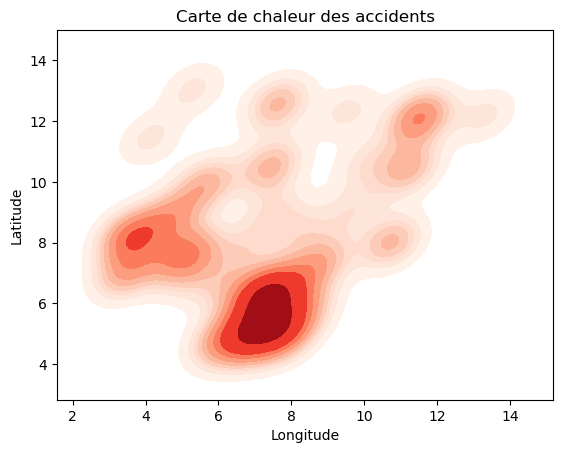

In [43]:

df_car = df.select("Latitude", "Longitude").dropna().sample(fraction=0.1)
pandas_df = df_car.toPandas()

sns.kdeplot(data=pandas_df, x="Longitude", y="Latitude", cmap="Reds", fill=True, bw_adjust=0.5)
plt.title("Carte de chaleur des accidents")
plt.show()

##### Distribution du total des vehicules implique

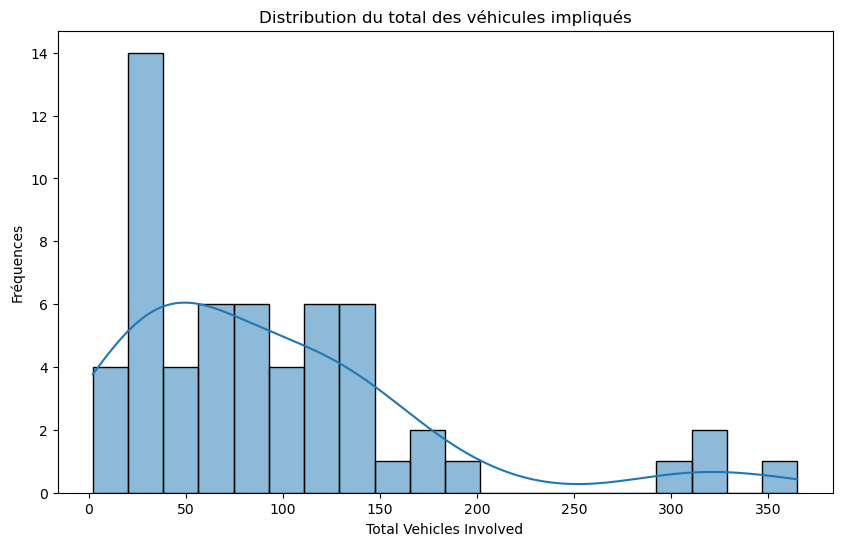

In [45]:

df_s = df.select("Total_Vehicles_Involved").dropna().sample(fraction=0.1)

pandas_df = df_s.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['Total_Vehicles_Involved'], bins=20, kde=True)
plt.title('Distribution du total des véhicules impliqués')
plt.xlabel('Total Vehicles Involved')
plt.ylabel('Fréquences')
plt.show()


from IPython.display import HTML

HTML("""
<div style="background-color: green; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Optimisation de modele
  </h2>
</div>
""")


In [48]:
df = df.toPandas()

In [49]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#### Création de la cible binaire : est-ce que l'accident est mortel ?

In [384]:
df['is_mortal'] = df['Num_Killed'].apply(lambda x: 1 if x > 0 else 0)

### Encoder

In [417]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#### KNEIGHBORS

In [555]:

cat_features = ['Quarter', 'State', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors']

# Colonnes numériques
num_features = ['Total_Crashes', 'Num_Injured', 'Total_Vehicles_Involved', 'Latitude', 'Longitude']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])


model = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])


X = df.drop(columns=['Num_Killed', 'is_mortal'])
y = df['is_mortal']


In [557]:
# split et train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [559]:
# Entraînement de notre model

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Total_Crashes',
                                                   'Num_Injured',
                                                   'Total_Vehicles_Involved',
                                                   'Latitude', 'Longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Quarter', 'State', 'SPV',
                                                   'DAD', 'PWR', 'FTQ',
                                                   'Other_Factors'])])),
                ('knn', KNeighborsClassifier())])

In [561]:
model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['Total_Crashes', 'Num_Injured',
                                     'Total_Vehicles_Involved', 'Latitude',
                                     'Longitude']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['Quarter', 'State', 'SPV', 'DAD', 'PWR',
                                     'FTQ', 'Other_Factors'])])),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                  ['Total_Crashes', 'Num_Injured',
                                   'Total_Vehicles_Involved', 'Latitude',
                                   'Longitude']),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  ['Quarter', 'State', 'SPV', 'DAD',

In [563]:
 model.predict(X_test)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [565]:
model.score(X_test, y_test)

0.9923076923076923

In [426]:
params = {
    'metric': ['minkowski','euclidean'], 
    'n_neighbors': [3, 2, 4, 5],
    'p': [2,6,1,10]
}

In [428]:
grid = GridSearchCV(KNeighborsClassifier(), param_grid=params , cv=4)

In [437]:
grid.fit(X_train.values, y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean'],
                         'n_neighbors': [3, 2, 4, 5], 'p': [2, 6, 1, 10]})

In [440]:
grid.best_params_

{'metric': 'minkowski', 'n_neighbors': 3, 'p': 1}

In [443]:
model = grid.best_estimator_

In [446]:
model.score(X_test.values , y_test)

1.0

#### Linear Regression

In [451]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)


LinearRegression()

In [537]:
#pour la prediction
m_p = model_lr.predict(X_test)
m_p

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [456]:
model_lr.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [459]:
params = {
     'copy_X': [True, False],
   'n_jobs': [None, 10, 20],
    
}  

In [498]:
model_lr.score(X_test , y_test)

0.0

In [539]:
(mean_squared_error(y_test, m_p))

5.850086280304859e-32

In [541]:
(r2_score(y_test, m_p))

0.0

#### Random Forest

In [470]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [473]:
# predire le model
p_rf= model_rf.predict(X_test)
p_rf

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.98, 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [476]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [479]:
params = {
     'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}   

In [482]:
grid = GridSearchCV(RandomForestRegressor(), param_grid=params, cv=5)  

In [485]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [487]:
grid.best_params_

{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

In [500]:
model_rf = grid.best_estimator_

In [502]:
model_rf.score(X_test , y_test)

0.0

In [529]:
(mean_squared_error(y_test, p_rf))

3.0769230769230825e-06

In [531]:
(r2_score(y_test, p_rf))

0.0

#### SVR

In [507]:
model_svr = SVR()
model_svr.fit(X_train, y_train)

SVR()

In [510]:
ms_pred = model_svr.predict(X_test)

In [513]:
#pour la prediction
model_svr.predict(X_test)

array([0.9055073 , 0.90079071, 0.90034911, 0.91239233, 0.90773187,
       0.9071745 , 0.9125602 , 0.90824678, 0.91543825, 0.90454734,
       0.9005858 , 0.89952771, 0.90913862, 0.9044057 , 0.90388773,
       0.90281932, 0.91157438, 0.90767492, 0.90166256, 0.90561649,
       0.91416984, 0.9001706 , 0.90667382, 0.90611245, 0.90084754,
       0.9054135 , 0.91091077, 0.90121239, 0.90585927, 0.91217447,
       0.90904   , 0.90695154, 0.89980814, 0.90582381, 0.90289923,
       0.89943051, 0.91068012, 0.90433149, 0.92065628, 0.90433452,
       0.89816595, 0.90989119, 0.91263858, 0.91551187, 0.90790907,
       0.90239025, 0.90698665, 0.90193193, 0.90039663, 0.90907299,
       0.89875889, 0.90166165, 0.90785337, 0.90081548, 0.90491866,
       0.90161019, 0.90966702, 0.90360711, 0.90311876, 0.89964996,
       0.9082568 , 0.9093892 , 0.91035342, 0.91609789, 0.90995956,
       0.90280204, 0.91431857, 0.90861453, 0.8975832 , 0.90679468,
       0.90674418, 0.91638028, 0.90065169, 0.91374115, 0.91557

In [516]:
model_svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [519]:
(mean_squared_error(y_test, ms_pred))

0.008714082417933436

In [522]:
(r2_score(y_test, ms_pred))

0.0

In [525]:
model_svr.score(X_test, y_test)

0.0

from IPython.display import HTML

HTML("""
<div style="background-color: pink; text-align: center;">
  <h2 style="margin: auto; padding: 20px; color: #ffffff;">
    Apache Sedona
  </h2>
</div>
""")


In [104]:
pip install ipywidgets ipyleaflet

In [38]:
pip install apache-sedona[spark]

Note: you may need to restart the kernel to use updated packages.


In [106]:
import json
import os
import shutil
import urllib3

import pandas as pd
import numpy as np

import pyspark
from pyspark.sql import SparkSession

from sedona.register import SedonaRegistrator  
from sedona.utils import SedonaKryoRegistrator, KryoSerializer

from ipyleaflet import Map, basemaps, basemap_to_tiles, MarkerCluster, Marker, AwesomeIcon
from ipywidgets import Layout

#### Creer une session sedona

In [56]:
 
# Configuration de la session Spark
spark = SparkSession.\
    builder.\
    master(f"local[*]").\
    appName("Sedona App").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
    config('spark.jars.packages',
           'com.acervera.osm4scala:osm4scala-spark3-shaded_2.12:1.0.11,'
           'org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.4.0,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2') .\
    getOrCreate()

sedona = SedonaContext.create(spark)

print(f"Spark version: {spark.version}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

Spark version: 3.5.4
Spark UI: http://DESKTOP-D5B1M8K:4040


##### Verifier que apache sedona fonctionne bien

In [59]:
# Verifions que apache sedona fonctionne
sedona.sql("SELECT ST_Point(1.0, 2.0) AS geom").show()

+-----------+
|       geom|
+-----------+
|POINT (1 2)|
+-----------+



##### Creer des points ST_Point avec lesquels on va traviller

In [62]:
from pyspark.sql.functions import expr
# on va creer des pont ST_point avec une requete sql via sedona
df = df.withColumn("geometry", expr("ST_Point(cast(Longitude as double), cast(Latitude as double))"))
#On creer une vue avec laqual on pourra effectuer toutes nos requetes
df.createOrReplaceTempView("accidents")


In [64]:
# on affiche les point creer
spark.sql("SELECT ST_AsText(geometry) FROM accidents LIMIT 5").show(truncate=False)

+-----------------------------+
|st_astext(geometry)          |
+-----------------------------+
|POINT (7.5153071 5.4540953)  |
|POINT (12.3881887 9.5129772) |
|POINT (7.7966205 4.9906379)  |
|POINT (6.9531842 6.2183136)  |
|POINT (10.0287754 10.6228284)|
+-----------------------------+



#### Charger notre fichier shalpefile et creer une vue

In [88]:
import geopandas as gpd

# Charger shapefile
gdf = gpd.read_file("nga_adm_osgof_20190417_em_SHP/nga_admbnda_adm1_osgof_20190417_em.shp")

# Convertir géométrie en WKT
gdf['geometry_wkt'] = gdf['geometry'].apply(lambda geom: geom.wkt if geom is not None and geom.is_valid else None)

# Sauvegarder en CSV
gdf.to_csv("nigeria_states_wkt.csv", index=False)


In [92]:
from pyspark.sql.functions import expr

df_etat = spark.read.option("header", True).csv("nigeria_states_wkt.csv")
df_etat = df_etat.withColumn("geometry", expr("ST_GeomFromWKT(geometry)"))
df_etat.createOrReplaceTempView("states")

###  Requetes avec sedona

##### Calculer la distance d'un point donnee et tous les etats

In [123]:
point_wkt = "POINT(7.5 9.1)"

query = f"""
SELECT ADM1_EN, ST_Distance(ST_Centroid(geometry), ST_GeomFromWKT('{point_wkt}')) as dist
FROM states
ORDER BY dist
LIMIT 5
"""

result = spark.sql(query)
result.show()

+--------------------+-------------------+
|             ADM1_EN|               dist|
+--------------------+-------------------+
|Federal Capital T...|0.36557379149308133|
|            Nasarawa|  0.913632344202832|
|              Kaduna|  1.308678590009159|
|                Kogi|  1.587515847401883|
|             Plateau| 2.0164020539380183|
+--------------------+-------------------+



##### total blesse par etat

In [137]:
query_blesse = """
WITH accidents_geom AS (
    SELECT *,
           ST_Point(cast(Longitude as double), cast(Latitude as double)) AS geom
    FROM accidents
)

SELECT s.ADM1_EN AS state,
       SUM(a.Num_Injured) AS total_blesse
FROM accidents_geom a
JOIN states s
  ON ST_Contains(s.geometry, a.geom)
GROUP BY s.ADM1_EN
ORDER BY total_blesse DESC
LIMIT 10
"""
result_blesse = spark.sql(query_blesse)
result_blesse.show()


+--------------------+------------+
|               state|total_blesse|
+--------------------+------------+
|              Kaduna|       11264|
|Federal Capital T...|        8805|
|                Ogun|        8713|
|            Nasarawa|        7401|
|               Niger|        7132|
|              Bauchi|        6889|
|                 Oyo|        5496|
|              Jigawa|        5327|
|                Kogi|        5184|
|                Kano|        4488|
+--------------------+------------+



##### Les etats avec le plus d'accidents

In [142]:
query = """WITH accidents_geom AS (
    SELECT *,
        ST_Point(cast(Longitude as double), cast(Latitude as double)) AS geom
    FROM accidents
)

SELECT s.ADM1_EN AS state,
       SUM(a.Total_Crashes) AS total_accidents
FROM accidents_geom a
JOIN states s
ON ST_Contains(s.geometry, a.geom)
GROUP BY s.ADM1_EN
ORDER BY total_accidents DESC
LIMIT 5
"""
spark.sql(query).show()

+--------------------+---------------+
|               state|total_accidents|
+--------------------+---------------+
|Federal Capital T...|           4852|
|                Ogun|           3780|
|            Nasarawa|           2946|
|              Kaduna|           2784|
|                 Oyo|           2084|
+--------------------+---------------+



##### Les facteurs contribuant le plus aux accidents

In [147]:
query= """SELECT
    SUM(SPV) AS total_SPV,
    SUM(DAD) AS total_DAD,
    SUM(PWR) AS total_PWR,
    SUM(FTQ) AS total_FTQ,
    SUM(Other_Factors) AS total_Other_Factors
FROM accidents"""
spark.sql(query).show()

+---------+---------+---------+---------+-------------------+
|total_SPV|total_DAD|total_PWR|total_FTQ|total_Other_Factors|
+---------+---------+---------+---------+-------------------+
|    19634|       73|      184|    12341|              19914|
+---------+---------+---------+---------+-------------------+



##### Le nombre d'accidents dans l'etat de Lagos par trimestre

In [154]:
query = """WITH accidents_geom AS (
    SELECT *,
        ST_Point(cast(Longitude as double), cast(Latitude as double)) AS geom
    FROM accidents
),
lagos_geom AS (
    SELECT geometry
    FROM states
    WHERE ADM1_EN = 'Lagos'
)

SELECT a.Quarter,
       SUM(a.Total_Crashes) AS crashes_quarter
FROM accidents_geom a
JOIN lagos_geom l
  ON ST_Contains(l.geometry, a.geom)
GROUP BY a.Quarter
ORDER BY a.Quarter"""
spark.sql(query).show()

+-------+---------------+
|Quarter|crashes_quarter|
+-------+---------------+
|Q1 2021|            151|
|Q1 2022|            198|
|Q1 2023|            113|
|Q1 2024|            113|
|Q2 2021|            145|
|Q2 2022|            148|
|Q2 2023|            138|
|Q3 2021|            141|
|Q3 2022|            146|
|Q3 2023|            106|
|Q4 2020|            113|
|Q4 2021|            159|
|Q4 2022|            167|
|Q4 2023|            101|
+-------+---------------+



#### Afficher la carte du nigeria

In [95]:
df = pd.read_csv("Accident.csv")  
print(df.columns)

Index(['Quarter', 'State', 'Total_Crashes', 'Num_Injured', 'Num_Killed',
       'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors',
       'Latitude', 'Longitude'],
      dtype='object')


##### On prepare une liste pour la localisation

In [98]:
locat = list(zip(df['Latitude'], df['Longitude']))

##### on creer les marqueurs et les clustere 

In [194]:
import folium
from folium.plugins import MarkerCluster


locat = list(zip(df['Latitude'], df['Longitude']))


latitudes = [loc[0] for loc in locat]
longitudes = [loc[1] for loc in locat]
milieu = [sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)]


m = folium.Map(location=milieu, zoom_start=7)


marker_cluster = MarkerCluster().add_to(m)


for loc in locat:
    folium.Marker(location=loc).add_to(marker_cluster)


m


In [206]:
import folium

locat = list(zip(df['Latitude'], df['Longitude'], df['Num_Killed'], df['Num_Injured']))

latitudes = [loc[0] for loc in locat]
longitudes = [loc[1] for loc in locat]
milieu = [sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)]

m = folium.Map(location=milieu, zoom_start=7, tiles='CartoDB dark_matter')

for lat, lon, morts, blesses in locat:
    if morts >= 5:
        color = 'red'
    elif morts >= 1:
        color = 'orange'
    else:
        color = 'green'

    popup_html = f"""
    <div style="font-family: Arial; font-size: 14px; padding: 8px; color: white; background-color: #333; border-radius: 8px; width: 180px;">
        <h4 style="margin-top:0; color: #ffcc00;"> Détails accident</h4>
        <p><b> Morts :</b> {morts}</p>
        <p><b> Blessés :</b> {blesses}</p>
    </div>
    """

    popup = folium.Popup(popup_html, max_width=250)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.Icon(color=color, icon='heartbeat', prefix='fa')
    ).add_to(m)

m


### Geopandas

In [96]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Exemple CSV d'accidents avec colonnes latitude, longitude, gravite, date
accidents_df = pd.read_csv("Accident.csv")

# Convertir en GeoDataFrame avec géométrie Point
accidents_gdf = gpd.GeoDataFrame(
    accidents_df, 
    geometry=gpd.points_from_xy(accidents_df.Longitude, accidents_df.Latitude),
    crs="EPSG:4326"
)

print(accidents_gdf.head())


   Quarter      State  Total_Crashes  Num_Injured  Num_Killed  \
0  Q4 2020       Abia             30          146          31   
1  Q4 2020    Adamawa             77          234          36   
2  Q4 2020  Akwa Ibom             22           28           7   
3  Q4 2020    Anambra             72          152          20   
4  Q4 2020     Bauchi            154          685          90   

   Total_Vehicles_Involved  SPV  DAD  PWR  FTQ  Other_Factors   Latitude  \
0                       37   19    0    0    0             18   5.454095   
1                       94   57    0    0    0             37   9.512977   
2                       24   15    0    0    1              8   4.990638   
3                       83   43    1    0    0             39   6.218314   
4                      140   74    0    0    0             66  10.622828   

   Longitude                   geometry  
0   7.515307     POINT (7.51531 5.4541)  
1  12.388189   POINT (12.38819 9.51298)  
2   7.796621    POINT (7.7

In [98]:
zones_gdf = gpd.read_file("nga_adm_osgof_20190417_em_SHP/nga_admbnda_adm1_osgof_20190417_em.shp")

In [100]:
zones_gdf = zones_gdf.to_crs(epsg=32632)
accidents_gdf = accidents_gdf.to_crs(epsg=32632)

In [108]:
accidents_par_etat = accidents_with_state.groupby('ADM1_EN')['Total_Crashes'].sum().reset_index()
print(accidents_par_etat.sort_values(by='Total_Crashes', ascending=False).head(10))

                      ADM1_EN  Total_Crashes
14  Federal Capital Territory           4852
27                       Ogun           3780
25                   Nasarawa           2946
18                     Kaduna           2784
30                        Oyo           2084
24                      Lagos           1939
26                      Niger           1908
4                      Bauchi           1661
22                       Kogi           1651
28                       Ondo           1526


In [110]:
# Somme de chaque facteur (en supposant que ce soit des compteurs ou indicateurs)
facteurs = ['SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors']
facteurs_sum = accidents_with_state[facteurs].sum().sort_values(ascending=False)
print(facteurs_sum)

Other_Factors    19914
SPV              19634
FTQ              12341
PWR                184
DAD                 73
dtype: int64


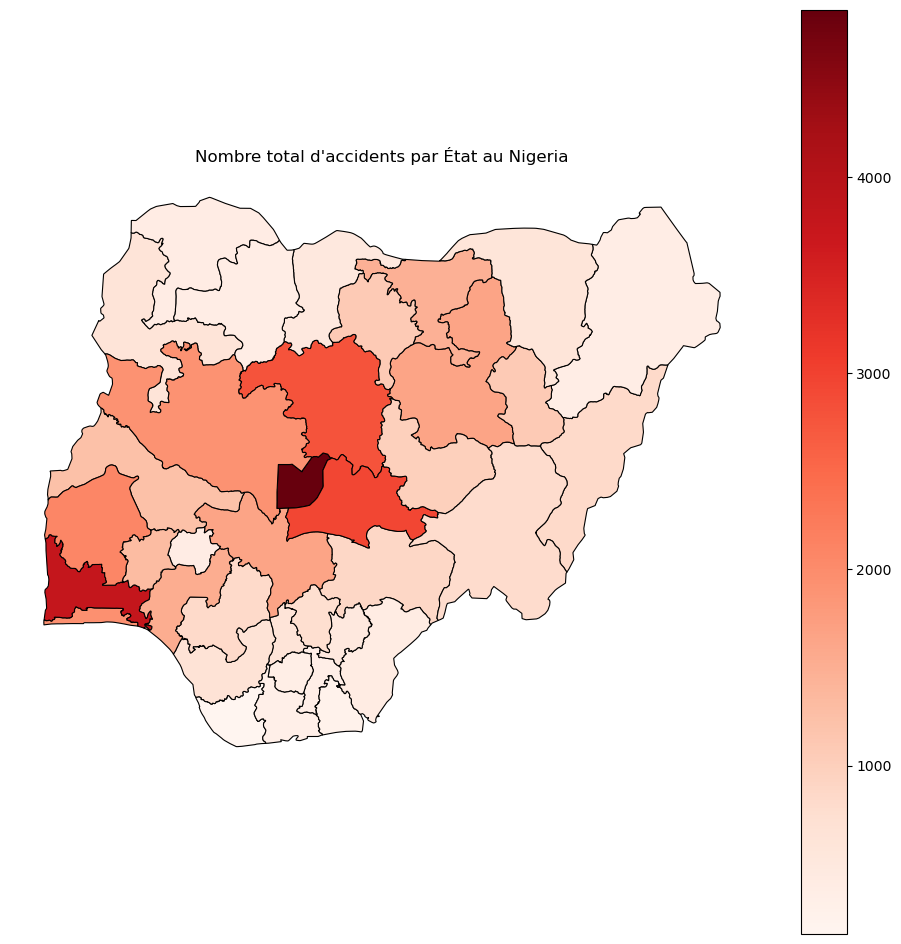

In [114]:
# Joindre les totaux au GeoDataFrame des états
nigeria_utm = nigeria_utm.merge(accidents_par_etat, left_on='ADM1_EN', right_on='ADM1_EN', how='left')

# Remplacer les NaN par 0
nigeria_utm['Total_Crashes'] = nigeria_utm['Total_Crashes'].fillna(0)

# Carte
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nigeria_utm.plot(column='Total_Crashes', cmap='Reds', linewidth=0.8, edgecolor='black', legend=True, ax=ax)
plt.title("Nombre total d'accidents par État au Nigeria")
plt.axis('off')
plt.show()

In [116]:
# 6. Analyse des facteurs contributifs moyens par accident (moyenne par état)
facteurs = ['SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors']

facteurs_moyens = accidents_with_state.groupby('ADM1_EN')[facteurs].mean().reset_index()
print("\nMoyenne des facteurs contributifs par État (extrait):")
print(facteurs_moyens.head())


Moyenne des facteurs contributifs par État (extrait):
     ADM1_EN        SPV       DAD       PWR        FTQ  Other_Factors
0       Abia   6.642857  0.071429  0.142857   5.357143      14.000000
1    Adamawa  26.214286  0.000000  0.000000  19.571429      23.285714
2  Akwa Ibom   6.714286  0.000000  0.071429   5.214286       5.214286
3    Anambra  16.142857  0.071429  0.142857   6.928571      33.571429
4     Bauchi  42.500000  0.071429  0.142857  31.928571      55.714286


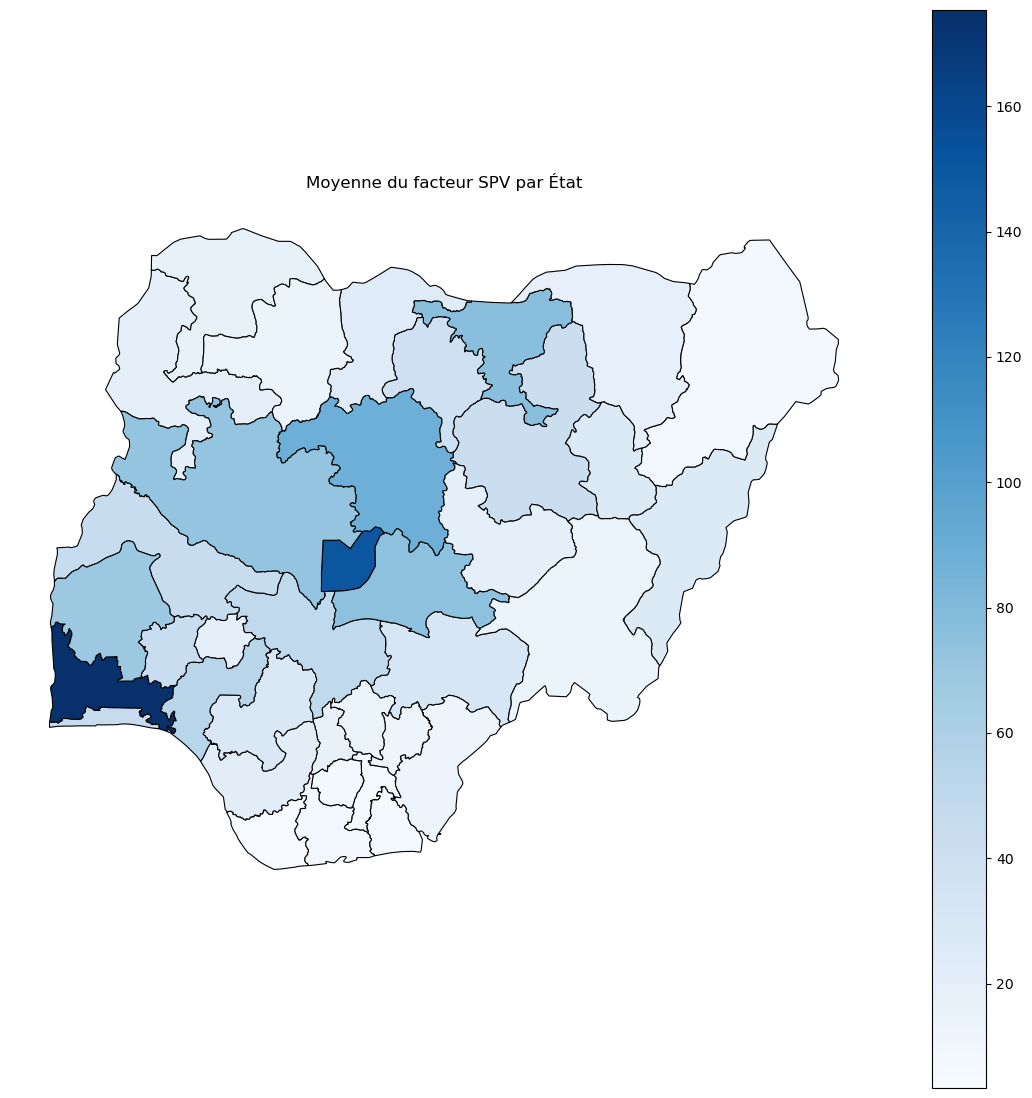

In [118]:
# 7. Visualiser un facteur contributif (exemple SPV) sur la carte
nigeria_utm = nigeria_utm.merge(facteurs_moyens[['ADM1_EN', 'SPV']], on='ADM1_EN', how='left')
nigeria_utm['SPV'] = nigeria_utm['SPV'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(14, 14))
nigeria_utm.plot(column='SPV', cmap='Blues', linewidth=0.8, edgecolor='black', legend=True, ax=ax)
plt.title("Moyenne du facteur SPV par État")
plt.axis('off')
plt.show()

#### SURFACE

In [121]:
# Charger le shapefile (supposons qu'il est en WGS84)
shapefile_path = "nga_adm_osgof_20190417_em_SHP/nga_admbnda_adm1_osgof_20190417_em.shp"
gdf = gpd.read_file(shapefile_path)

# Vérifier la projection initiale
print("Projection initiale :", gdf.crs)

Projection initiale : EPSG:4326


In [123]:
# Reprojeter en UTM (exemple pour zone 32N, EPSG:32632)
gdf_utm = gdf.to_crs(epsg=32632)

# Calculer la surface en mètres carrés
gdf_utm['area_m2'] = gdf_utm.geometry.area

In [129]:
# Conversion en km²
gdf_utm['area_km2'] = gdf_utm['area_m2'] / 1e6

# Affichage des résultats
print(gdf_utm[['ADM1_EN', 'area_m2', 'area_km2']].head())

     ADM1_EN       area_m2      area_km2
0       Abia  4.858882e+09   4858.882335
1    Adamawa  3.789350e+10  37893.497780
2  Akwa Ibom  6.716316e+09   6716.315768
3    Anambra  4.807933e+09   4807.933356
4     Bauchi  4.849640e+10  48496.400355


In [131]:
# État avec la plus grande surface
max_surface = gdf_utm.loc[gdf_utm['area_km2'].idxmax()]
print("État avec la plus grande surface :")
print(f"{max_surface['ADM1_EN']} - {max_surface['area_km2']:.2f} km²")

# État avec la plus petite surface
min_surface = gdf_utm.loc[gdf_utm['area_km2'].idxmin()]
print("\nÉtat avec la plus petite surface :")
print(f"{min_surface['ADM1_EN']} - {min_surface['area_km2']:.2f} km²")

État avec la plus grande surface :
Borno - 72665.88 km²

État avec la plus petite surface :
Lagos - 3647.41 km²
